In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import torch
import torchvision.transforms as transforms
from dataset import ImageDataset
from PIL import Image
from models import ResnetGenerator_our, NLayerDiscriminator
from make_args import Args
from torch.utils.data import DataLoader

- args

In [2]:
args = Args('./config/summer2winter_multi_gpu.json')

- dataloader

In [3]:
# test_transforms_ = [
#     transforms.Resize(int(args.img_height * 1.12), Image.BICUBIC),
#     transforms.RandomCrop((args.img_height, args.img_width)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ]
test_transforms_ = [
    transforms.Resize(int(args.img_height), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
testdataset = ImageDataset(args.data_path, transforms_=test_transforms_, unaligned=False, mode='test')
test_dataloader = DataLoader(
    testdataset,
    batch_size=1,
    shuffle=False,
    num_workers=args.num_workers)

- load trained model

In [15]:
weights = torch.load('./model_result/Summer2Winter/Translation_Model_200epochs.pth')

input_shape = (args.channels, args.img_height, args.img_width)
G_AB = ResnetGenerator_our(input_nc=args.channels, output_nc=None, ngf=args.ngf, n_blocks=args.n_blocks).to('cuda')
G_BA = ResnetGenerator_our(input_nc=args.channels, output_nc=None, ngf=args.ngf, n_blocks=args.n_blocks).to('cuda')
G_AB.load_state_dict(weights['G_AB'])
G_BA.load_state_dict(weights['G_BA'])
G_AB.to("cuda").eval()
G_BA.to("cuda").eval()

ResnetGenerator_our(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (conv1_norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (resnet_blocks): Sequential(
    (0): resnet_block(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (conv1_norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (conv2_norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (1): resnet_block(
      (conv1): Conv2d(256, 2

- inference

In [36]:
se_idx = -4
sample = testdataset[se_idx]
img_A, img_B = sample['A'].unsqueeze(0).to('cuda'), sample['B'].unsqueeze(0).to('cuda')

A2B = G_AB(img_A)
B2A = G_BA(A2B)

- visualization

In [37]:
A2B = np.transpose(A2B[0].data.cpu().numpy(), (1, 2, 0))
B2A = np.transpose(B2A[0].data.cpu().numpy(), (1, 2, 0))

A2B_origin = np.uint8(((A2B * 0.5) + 0.5) * 255)
B2A_origin = np.uint8(((B2A * 0.5) + 0.5) * 255)

img_A_origin = np.transpose(img_A[0].data.cpu().numpy(), (1, 2, 0))
img_A_origin = np.uint8(((img_A_origin * 0.5) + 0.5) * 255)

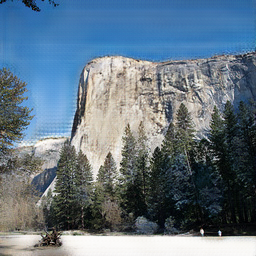

In [38]:
Image.fromarray(A2B_origin)

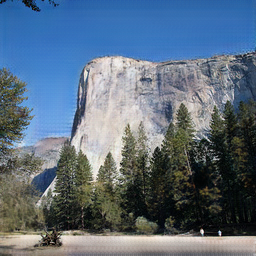

In [39]:
Image.fromarray(B2A_origin)

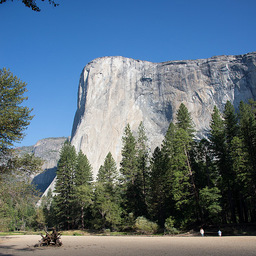

In [40]:
Image.fromarray(img_A_origin)